<a href="https://colab.research.google.com/github/marcinwolter/Tracking_student2022/blob/main/GNN_MuonE_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: GNNs for Particle Tracking

HEP.TrkX group

Steve Farrell, Daniel Murname

*Feb 2020*

Adapted for MuonE tracking by Marcin Wolter

*July 2020*

In [ ]:
!pip uninstall torchvision torchtext torchaudio --yes
!pip install torch==1.11.0+cu113  -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [ ]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

1.11.0+cu113
PyTorch version: None , CUDA version: 11.3


In [ ]:
#!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html
#!pip install torch-geometric

# MW corrected
!pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html


In [ ]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## The Problem

### Toy Data

In [ ]:
# Circle parameters
num_layers = 4 #10
height, width = 4, 4 #10, 10
min_curve, max_curve =  15, 50
noise = False
event_size_min, event_size_max = 2, 3 #4, 12 #I.E. The number of true particle tracks
max_angle= (5/6)*np.pi  # (4/6)*np.pi
feature_scale = np.array([10,10])

In [ ]:
# Some dumb circle calculations
def y1(x, r, a, sign):
    return sign*np.sqrt(r**2 - a**2) + np.sqrt(r**2 - (x-a)**2)
def y2(x, r, a, sign):
    return sign*np.sqrt(r**2 - a**2) - np.sqrt(r**2 - (x-a)**2)

# Generate random circle / helix parameters
def rand_pars(event_size_min, event_size_max, max_curve, min_curve):
    event_size = int(np.floor(np.random.random(1)*(event_size_max - event_size_min) + event_size_min))
    radii = np.random.random(event_size)*(max_curve - min_curve) + min_curve
    dirs = np.random.random(event_size)*(radii)*2 -radii
    sign_options = np.array([-1,1])
    signs = sign_options[np.rint(np.random.random(event_size)).astype(int)]
    return radii, dirs, signs, event_size

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Generate event data from random parameters
def gen_edge_class(event_size_min, event_size_max, curve_min, curve_max, height, num_layers, max_angle, feature_scale, iter, num_samples):
    
    """ Feed params into randomiser """
    while True:
        radii, dirs, signs, event_size = rand_pars(event_size_min, event_size_max, curve_max, curve_min)
        xys = []
        X = np.empty([3,1])
        x = np.arange(0 + height/num_layers,height + height/num_layers, height/num_layers)
        i = 0
        for r, d, s in zip(radii, dirs, signs):
            y1test = y1(x, r, d, s)
            y2test = y2(x, r, d, s)
            #print(y1test,y2test, x)
            if -2.5 < y1test[0] < 2.5 and not any(np.isnan(y1test)):
                X = np.append(X, np.vstack((y1test, np.array([i]*len(y1test)), x )), axis=1)
                i += 1
            if -2.5 < y2test[0] < 2.5 and not any(np.isnan(y2test)):
                X = np.append(X, np.vstack((y2test, np.array([i]*len(y2test)), x )), axis=1)
                i += 1
        #print(" X ",X)       
        X = X[:,1:].T
        #print("X.T ",X)
        np.random.shuffle(X)

        e = np.array([[i,j] for layer in np.arange(num_layers-1) for i in np.argwhere(X[:,2] == layer+1) for j in np.argwhere(X[:,2] == (layer+2)) if (X[i, 0] - np.tan(max_angle/2) < X[j, 0] < X[i, 0] + np.tan(max_angle/2))]).T.squeeze()
        #print("X = ",X)
        #print("e = ",e)

        # This handles when no edges were constructed. In that case, the randomisation is a do-over
        try:
            y = np.array([int(i[1] == j[1]) for i,j in zip(X[e[0]], X[e[1]])])    
            break
        except:
            pass
    if iter is not None and num_samples is not None:
        out.update(progress(iter, num_samples))    
    
    X = np.array([X[:,2], X[:,0]]).T / feature_scale

    data = Data(x = torch.from_numpy(X).float(), edge_index = torch.from_numpy(e), y = torch.from_numpy(y), pid = torch.from_numpy(X[:,1]))
    return data


In [ ]:
def plot_toy_graph(event, ylim=1.):
  
    #print(event)
    #print(event.x)
    #print(event.pid)
    #print(event.y)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()
#     for i, j in zip(X[e[0]], X[e[1]]):
#         plt.plot([i[0], j[0]], [i[1], j[1]], c='b')
    #     print(i[0], i[2], j[0], j[2])
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')
    plt.scatter(x, y, c='k')
    plt.ylim(-ylim,ylim)

In [ ]:
train_size, test_size = 1000, 1000
out = display(progress(0, train_size), display_id=True)
train_dataset = [gen_edge_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle, feature_scale, i, train_size) for i in range(train_size)]
out = display(progress(0, test_size), display_id=True)
test_dataset = [gen_edge_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle, feature_scale, i, test_size) for i in range(test_size)]
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


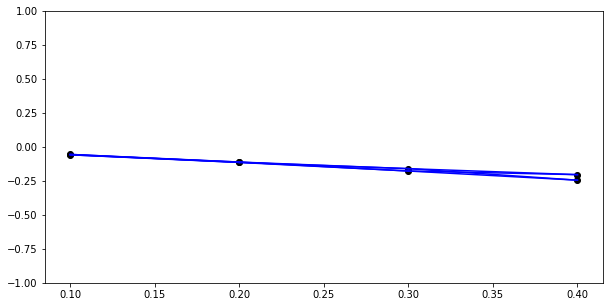

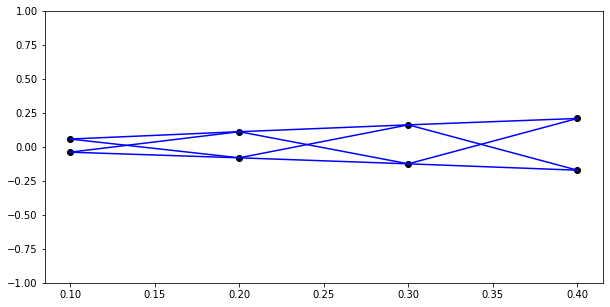

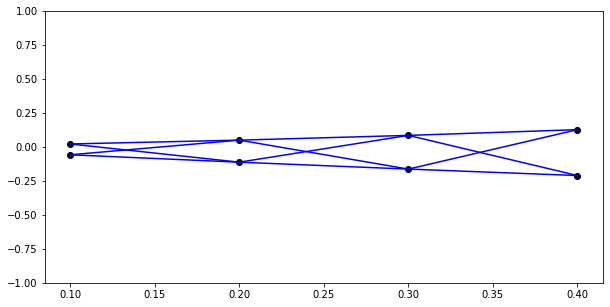

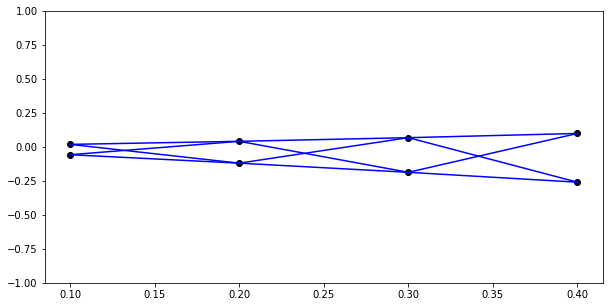

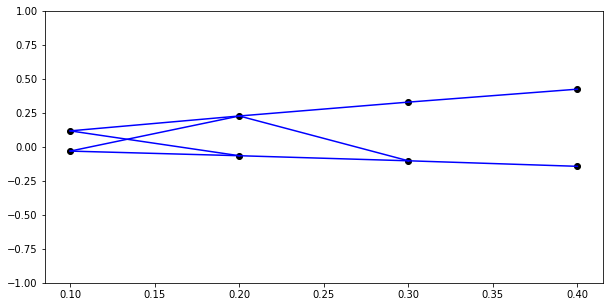

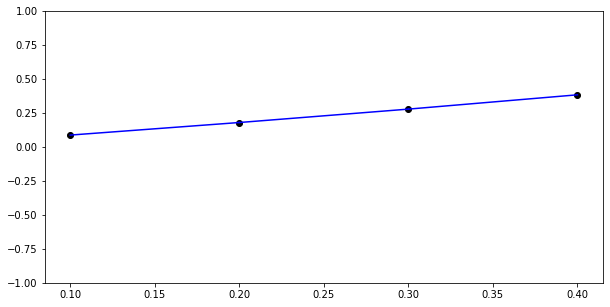

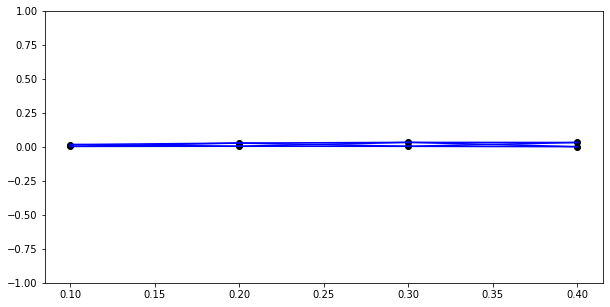

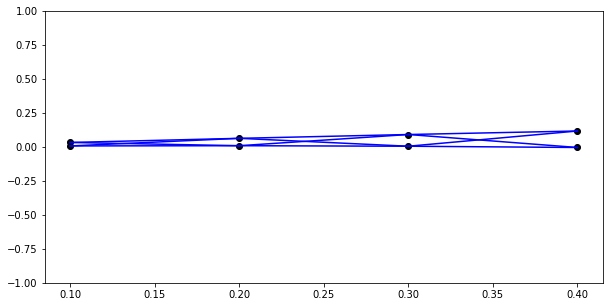

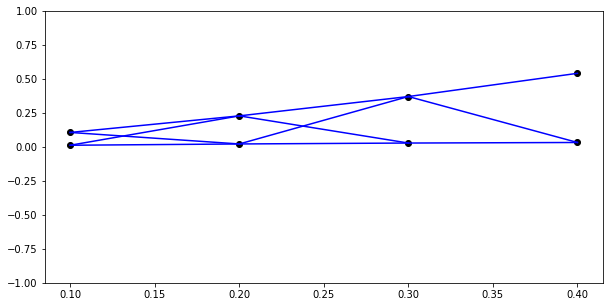

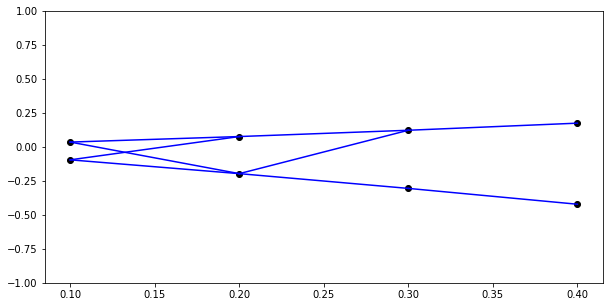

In [ ]:
for k in range(10):
   plot_toy_graph(test_dataset[k])

The complexity of the graph depends on the angle cut we put on it. Try increasing max_angle to, say, `(5/6)*np.pi` and the graph should be more busy. The limit is of course `(6/6)*np.pi = pi` where each node will look at the full angle of available possible nodes to form an edge with. While playing with this number, run the next cell to see the proportion of fake edges to true edges (fake/true) on the above graph. This value will be extremely useful later.

In [ ]:
print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

Fake / True =  0.5


## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Add the hidden features to the previous iteration (this helps to preserve information between messages)
5. Repeat (2) --> (4) n_graph_iters times
6. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [ ]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

Build a version of the model and print it out.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
model

MPNN_Network(
  (node_encoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_feature

### Training on Toy Data

In [ ]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [ ]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

We set a weight value that is more or less the (fake / true) ratio found above. This forces the loss function to punish incorrectly classified true edges more severely. It rebalances the distribution as if there was a 1:1 true:fake ratio.

In [ ]:
weight = 2

m_configs = {"input_dim": 2, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 6, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)

for epoch in range(200):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))



Epoch: 1, Accuracy: 0.5738
Epoch: 2, Accuracy: 0.5738
Epoch: 3, Accuracy: 0.5738
Epoch: 4, Accuracy: 0.5738
Epoch: 5, Accuracy: 0.5738
Epoch: 6, Accuracy: 0.5738
Epoch: 7, Accuracy: 0.5738
Epoch: 8, Accuracy: 0.5738
Epoch: 9, Accuracy: 0.5738
Epoch: 10, Accuracy: 0.5690
Epoch: 11, Accuracy: 0.5738
Epoch: 12, Accuracy: 0.5722
Epoch: 13, Accuracy: 0.5750
Epoch: 14, Accuracy: 0.5738
Epoch: 15, Accuracy: 0.5738
Epoch: 16, Accuracy: 0.5738
Epoch: 17, Accuracy: 0.5738
Epoch: 18, Accuracy: 0.5738
Epoch: 19, Accuracy: 0.5738
Epoch: 20, Accuracy: 0.5738
Epoch: 21, Accuracy: 0.5738
Epoch: 22, Accuracy: 0.5738
Epoch: 23, Accuracy: 0.5738
Epoch: 24, Accuracy: 0.5760
Epoch: 25, Accuracy: 0.5807
Epoch: 26, Accuracy: 0.5865
Epoch: 27, Accuracy: 0.5869
Epoch: 28, Accuracy: 0.5853
Epoch: 29, Accuracy: 0.5848
Epoch: 30, Accuracy: 0.5851
Epoch: 31, Accuracy: 0.5888
Epoch: 32, Accuracy: 0.6025
Epoch: 33, Accuracy: 0.6061
Epoch: 34, Accuracy: 0.5988
Epoch: 35, Accuracy: 0.5999
Epoch: 36, Accuracy: 0.6000
E

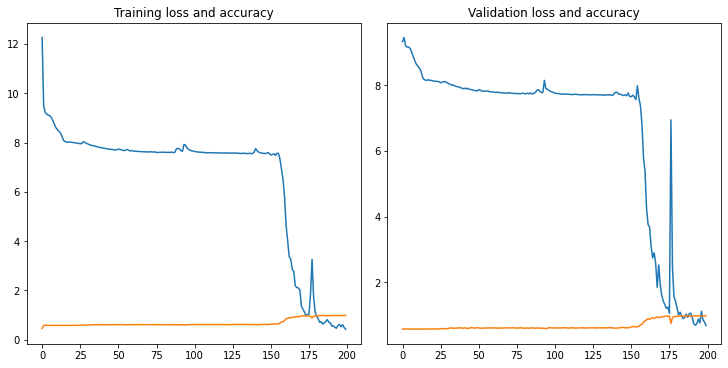

In [ ]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, np.arange(len(t_acc_v)), t_acc_v)
axs[0].set_title("Training loss and accuracy")
axs[0].set_yscale("linear")
axs[1].plot(np.arange(len(v_loss_v)), v_loss_v, np.arange(len(v_acc_v)), v_acc_v)
axs[1].set_title("Validation loss and accuracy")
axs[1].set_yscale("linear")

### Did it work?

Running the above with 1 graph iteration gives me about 90% accuracy in 200 epochs.

The best performance that I can get with some simple manual tuning is around 95% accuracy. We can improve the efficiency at the cost of purity by raising the weight on true edges, but the accuracy won't significantly improve. In general, the biggest changes were from increasing the width (i.e. the number of dimensions) of the hidden layers. We can visualise the performance on a particular graph, colouring true positives black, false positives red, true negatives a transparent black, and false negatives in blue.

In [ ]:
def plot_toy_classified(event, preds, cut=0.5):
    
    #print("New event")
        
    #print(event)
    #print(event.x)
    #print(event.pid)
    #print(event.y)
    #gprint(preds)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    
    preds = preds.detach().numpy()
    

    for j in range(len(labels)):
        
        #print(str('%01.2f' % preds[j])+" "+str(labels[j].item())+" "+str(x[edges[0,j]]*feature_scale)+","+str(y[edges[0,j]]*feature_scale)+" "+str(x[edges[1,j]]*feature_scale)+","+str(y[edges[1,j]]*feature_scale))
        s = str('%01.2f' % preds[j])+" "+str(labels[j].item())
        plt.text((x[edges[0,j]]+x[edges[1,j]])/2., (y[edges[0,j]]+y[edges[1,j]])/2.+np.random.random(1)*0.00, s, fontsize=12)

        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
                
        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])

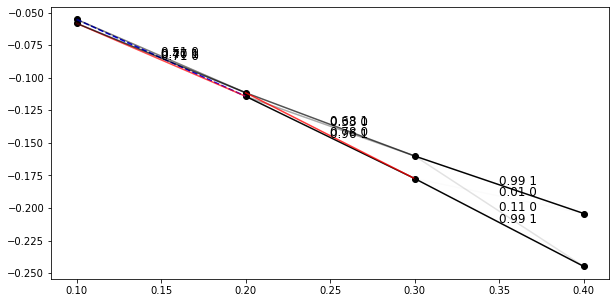

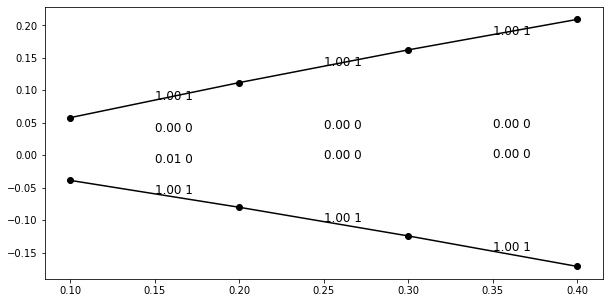

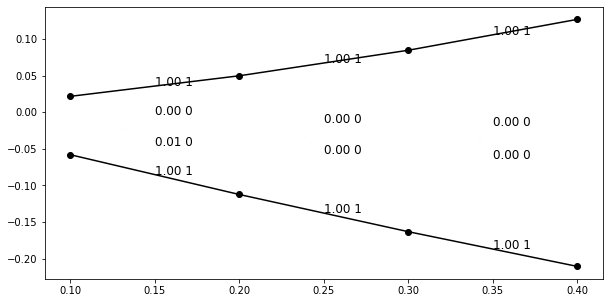

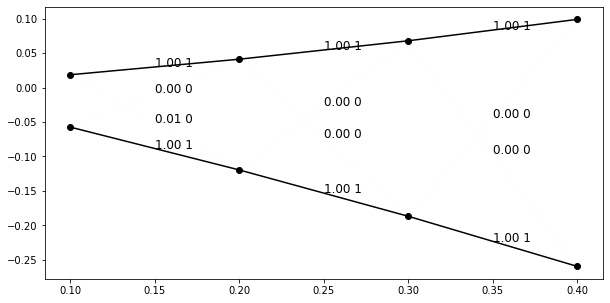

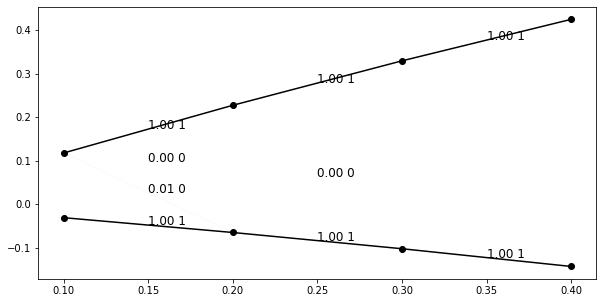

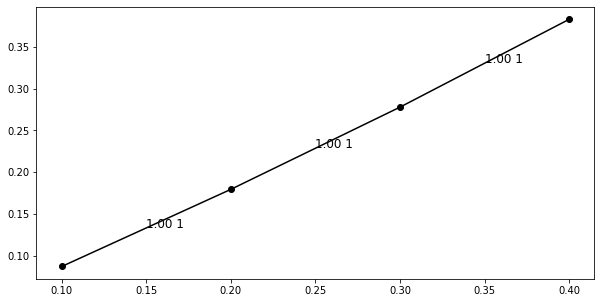

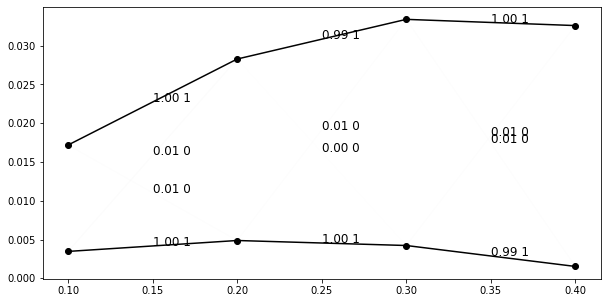

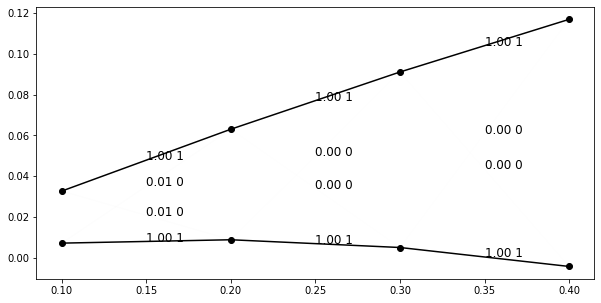

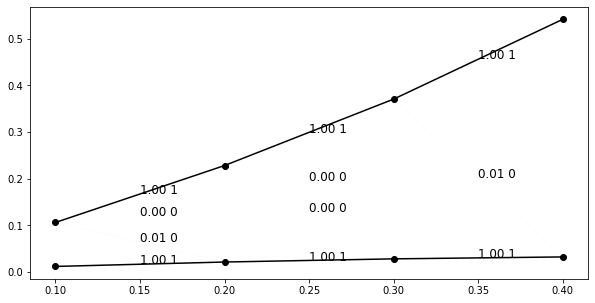

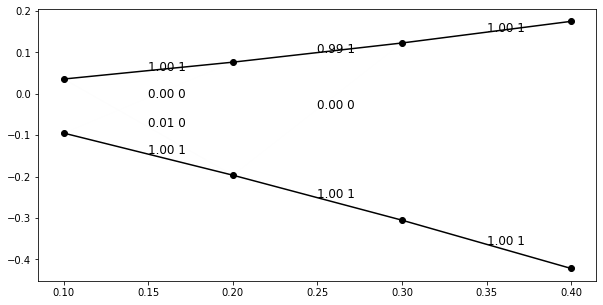

In [ ]:
for k in range(10):
   data = test_loader.dataset[k].to(device)
   preds = torch.sigmoid(model(data)).to('cpu')
   plot_toy_classified(data.to('cpu'), preds, cut = 0.6)

So we can see that it's working quite well. Few missed true edges, and few misclassified fake edges. The ratio of false positives to false negatives (which can be defined with efficiency and purity) is controlled by the cut we put on the prediction score. 

### The effect of Message Passing

In this simple example, the message passing does not do a huge amount. Going from 1 iteration to 6 iterations improves the accuracy to around 93% (from 90%). This improvement is washed out with more hidden dimensions, as one can see from the below set of tests. Try playing with more hidden node and edge dimensions (e.g. 64) and see if the message passing iterations can improve the performance.

Epoch: 1, Accuracy: 0.4262
Epoch: 2, Accuracy: 0.4262
Epoch: 3, Accuracy: 0.4262
Epoch: 4, Accuracy: 0.4262
Epoch: 5, Accuracy: 0.5549
Epoch: 6, Accuracy: 0.5738
Epoch: 7, Accuracy: 0.5738
Epoch: 8, Accuracy: 0.5738
Epoch: 9, Accuracy: 0.5738
Epoch: 10, Accuracy: 0.5738
Epoch: 11, Accuracy: 0.5738
Epoch: 12, Accuracy: 0.5738
Epoch: 13, Accuracy: 0.5738
Epoch: 14, Accuracy: 0.5738
Epoch: 15, Accuracy: 0.5738
Epoch: 16, Accuracy: 0.5738
Epoch: 17, Accuracy: 0.5738
Epoch: 18, Accuracy: 0.5738
Epoch: 19, Accuracy: 0.5738
Epoch: 20, Accuracy: 0.5738
Epoch: 21, Accuracy: 0.5738
Epoch: 22, Accuracy: 0.5754
Epoch: 23, Accuracy: 0.5883
Epoch: 24, Accuracy: 0.5876
Epoch: 25, Accuracy: 0.5768
Epoch: 26, Accuracy: 0.5918
Epoch: 27, Accuracy: 0.5955
Epoch: 28, Accuracy: 0.5869
Epoch: 29, Accuracy: 0.5966
Epoch: 30, Accuracy: 0.6602
Epoch: 31, Accuracy: 0.6806
Epoch: 32, Accuracy: 0.7107
Epoch: 33, Accuracy: 0.7242
Epoch: 34, Accuracy: 0.8409
Epoch: 35, Accuracy: 0.8655
Epoch: 36, Accuracy: 0.8867
E

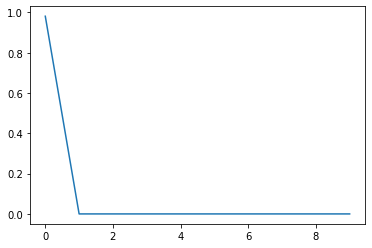

In [ ]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0
best_acc = np.zeros(10)
for i in range(1,2): #for i in range(1,11): # shorten to 2 iterations to speed up
    m_configs = {"input_dim": 2, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": i, "layer_norm": True}
    model = MPNN_Network(**m_configs).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
    for epoch in range(200):
        ep += 1  
        model.train()
        acc, total_loss = train(model, train_loader, optimizer)
        t_loss_v.append(total_loss)
        t_acc_v.append(acc)

        model.eval()
        acc, total_loss = evaluate(model, test_loader)
        if acc > best_acc[i-1]: best_acc[i-1] = acc
        v_loss_v.append(total_loss)
        v_acc_v.append(acc)

        print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))
plt.plot(np.arange(len(best_acc)), best_acc)

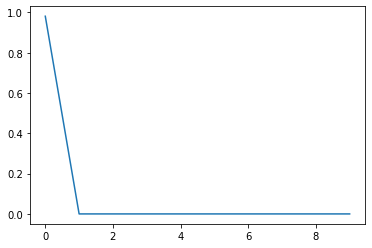

In [ ]:
plt.plot(np.arange(len(best_acc)), best_acc)



# **Load MuonE data and reconstruct tracks**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Circle parameters
num_layers = 14
height, width = 10, 10
#min_curve, max_curve =  1000, 1001 # 15, 50

max_angle = 1.*np.pi
feature_scale = 200.

# x and y multiplied by this scale (to get similar x/y and z spread)
xy_scale=100.

In [ ]:
import numpy as np
import pandas as pd

def readMuonE():

   event_file = "/content/drive/My Drive/MuonE_tracking/hitFile_medium.csv"

   data = pd.read_csv(event_file) 
   # Preview the first 5 lines of the loaded data 
   data.head()

   # Temporary nextZ  (next layer Z)
   layerZ0 =  [-999, -16, -21, 131, 151, 477, 497, 832, 843.7, 1146, 1141, 1252.7, 1266, 1973, 1960 ]



   #X = np.array([[0,0,0]])
   #print(X)
   
   
   iEventLast=data.iat[0,0]
   k=0
   Xcreated=False
   #dataOUTcreated=False
   dataOUT = []

   #iterate over input data
   for k, row in data.iterrows():
     ll=data.iat[k,0]
     #print("counter ",k,ll,iEventLast)
     if ll != iEventLast:

       '''
       for layer in np.arange(num_layers-1):
          print("XX=",layer,X)
          for i in np.argwhere(X[:,2] == layerZ0[layer+1]): 
            for j in np.argwhere(X[:,2] == layerZ0[layer+3]):
               if (X[i, 0] - 20. < X[j, 0] < X[i, 0] + 20.):
                   print("layer, i, j=",layer, i, j)
       '''
#       e = np.array([[i,j] for layer in np.arange(num_layers-1) for i in np.argwhere(X[:,2] == layer+1) for j in np.argwhere(X[:,2] == (layer+2))  if (X[i, 0] - np.tan(max_angle/2) < X[j, 0] < X[i, 0] + np.tan(max_angle/2))]).T.squeeze()

       e = np.array([[i,j] for layer in np.arange(num_layers-1) for i in np.argwhere(X[:,2] == 
              layerZ0[layer+1]) for j in np.argwhere(X[:,2] == layerZ0[layer+3])  if (X[i, 0] - np.tan(max_angle/2)*(layerZ0[layer+3]-layerZ0[layer+1]) < X[j, 0] < X[i, 0] + np.tan(max_angle/2)*(layerZ0[layer+3]-layerZ0[layer+1]))]).T.squeeze()

       #print(X)
       #print("e ",e) 
        # This handles when no edges were constructed. In that case, the randomisation is a do-over
       #try:
       y = np.array([int(i[1] == j[1]) for i,j in zip(X[e[0]], X[e[1]])])
       #     print("y = ",y)     
       #     break
       #except:
       #     pass

       #print("y = ",y) 
       #if iter is not None and num_samples is not None:
       #     out.update(progress(iter, num_samples))    


       X = np.array([X[:,2], X[:,0]]).T / feature_scale

       dataEvent = Data(x = torch.from_numpy(X).float(), edge_index = torch.from_numpy(e), y = torch.from_numpy(y), pid = torch.from_numpy(X[:,1]))

       #plot_toy_graph(dataEvent, 0.2)

       dataOUT.append(dataEvent)
#       if dataOUTcreated:
#         dataOUT = dataOUT.append(dataEvent)
#       else:
#         dataOUT = dataEvent 
#         dataOUTcreated = True

       Xcreated = False  
       iEventLast = ll

     #print(len(X)) 
     #print(k,ll,data.iat[k,2],Xcreated) 
     if data.iat[k,2]==0 and data.iat[k,5]<3 and data.iat[k,5]>0: # select X-hit and trackID=0,1,2
        if Xcreated:
          X = np.append(X,np.array([[data.iat[k,1]*xy_scale, data.iat[k,5], data.iat[k,3]  ]]),axis=0)
        else:
          X = np.array([[data.iat[k,1]*xy_scale, data.iat[k,5], data.iat[k,3]  ]]) 
          Xcreated=True
          #print("X created ",X)
     
   return dataOUT       





/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fake / True =  1.0
Training dataset (events):  4999
Test dataset (events):  5000


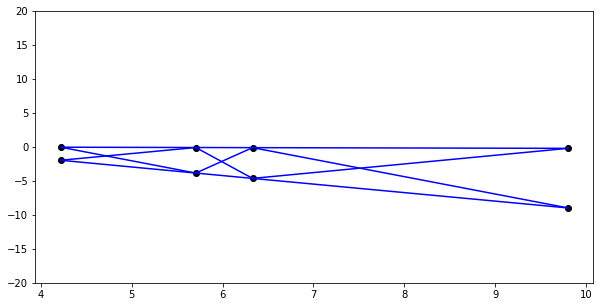

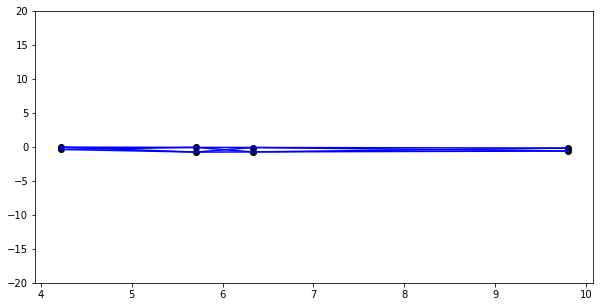

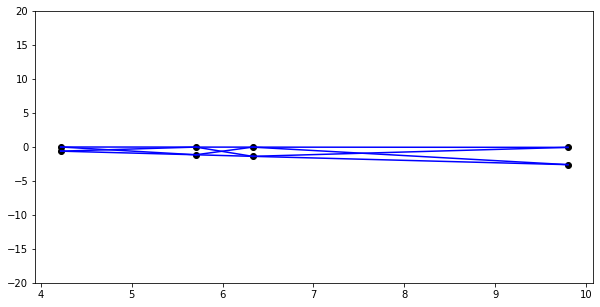

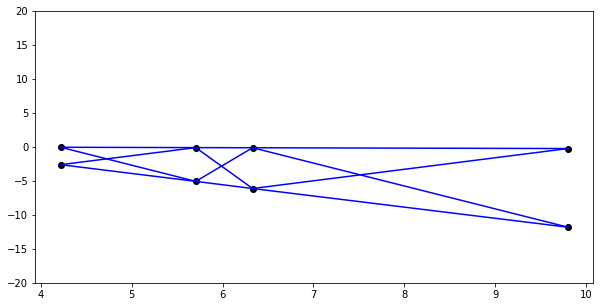

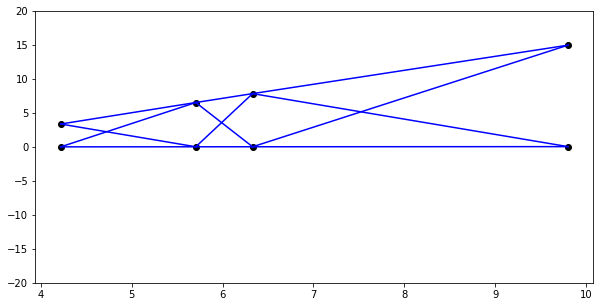

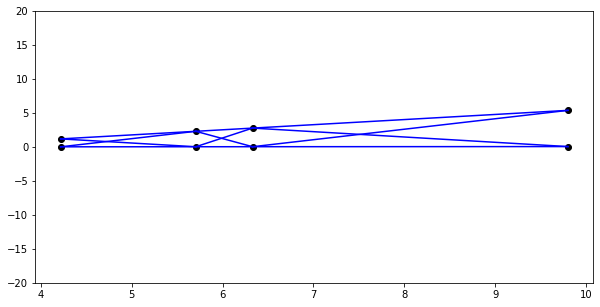

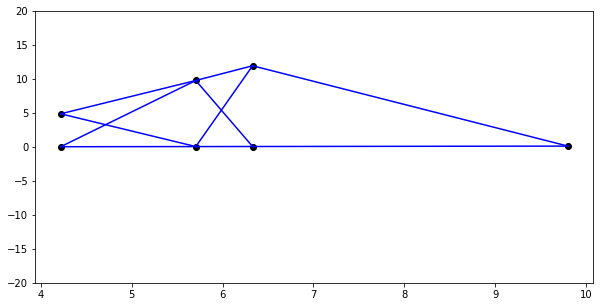

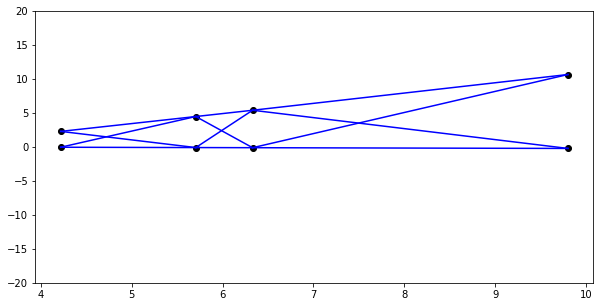

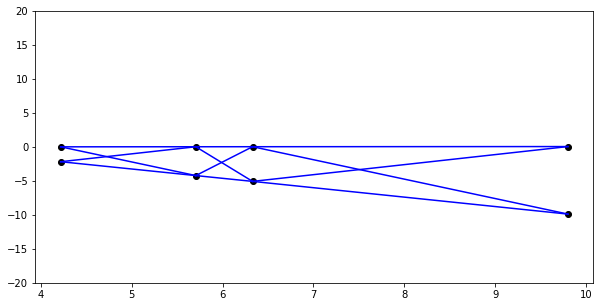

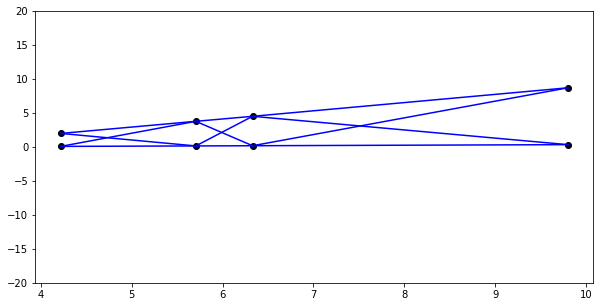

In [ ]:
# Read data and prepare for training

data = readMuonE()


# split data into training and test datasets
train_dataset = []
test_dataset = []
for k in range(len(data)):
  if (k%2 == 0):
    test_dataset.append(data[k])
  else:
    train_dataset.append(data[k])


train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)    

# Display few events
for k in range(10):
   plot_toy_graph(train_loader.dataset[k], 20.)


print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

print("Training dataset (events): ",len(train_dataset))
print("Test dataset (events): ",len(test_dataset))

# **Simple GNN**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
model

MPNN_Network(
  (node_encoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_feature

In [ ]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

We set a weight value that is more or less the (fake / true) ratio found above. This forces the loss function to punish incorrectly classified true edges more severely. It rebalances the distribution as if there was a 1:1 true:fake ratio.

In [ ]:
weight = 2

m_configs = {"input_dim": 2, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 6, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)

for epoch in range(50):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))



Epoch: 1, Accuracy: 0.7550
Epoch: 2, Accuracy: 0.9814
Epoch: 3, Accuracy: 0.9863
Epoch: 4, Accuracy: 0.9860
Epoch: 5, Accuracy: 0.9902
Epoch: 6, Accuracy: 0.9856
Epoch: 7, Accuracy: 0.9909
Epoch: 8, Accuracy: 0.9918
Epoch: 9, Accuracy: 0.9917
Epoch: 10, Accuracy: 0.9845
Epoch: 11, Accuracy: 0.9922
Epoch: 12, Accuracy: 0.9940
Epoch: 13, Accuracy: 0.9943
Epoch: 14, Accuracy: 0.9901
Epoch: 15, Accuracy: 0.9941
Epoch: 16, Accuracy: 0.9941
Epoch: 17, Accuracy: 0.9940
Epoch: 18, Accuracy: 0.9944
Epoch: 19, Accuracy: 0.9938
Epoch: 20, Accuracy: 0.9945
Epoch: 21, Accuracy: 0.9945
Epoch: 22, Accuracy: 0.9923
Epoch: 23, Accuracy: 0.9946
Epoch: 24, Accuracy: 0.9938
Epoch: 25, Accuracy: 0.9957
Epoch: 26, Accuracy: 0.9950
Epoch: 27, Accuracy: 0.9944
Epoch: 28, Accuracy: 0.9953
Epoch: 29, Accuracy: 0.9952
Epoch: 30, Accuracy: 0.9951
Epoch: 31, Accuracy: 0.9942
Epoch: 32, Accuracy: 0.9952
Epoch: 33, Accuracy: 0.9945
Epoch: 34, Accuracy: 0.9950
Epoch: 35, Accuracy: 0.9951
Epoch: 36, Accuracy: 0.9951
E

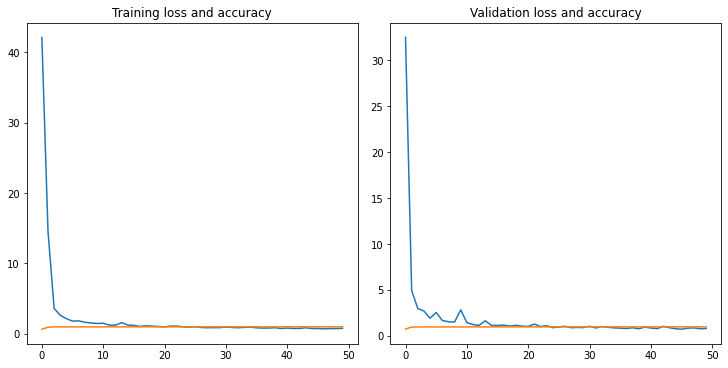

In [ ]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, np.arange(len(t_acc_v)), t_acc_v)
axs[0].set_title("Training loss and accuracy")
axs[0].set_yscale("linear")
axs[1].plot(np.arange(len(v_loss_v)), v_loss_v, np.arange(len(v_acc_v)), v_acc_v)
axs[1].set_title("Validation loss and accuracy")
axs[1].set_yscale("linear")

### Did it work?

![alt text](https://)Running the above with 1 graph iteration gives me about 80% accuracy in 200 epochs.

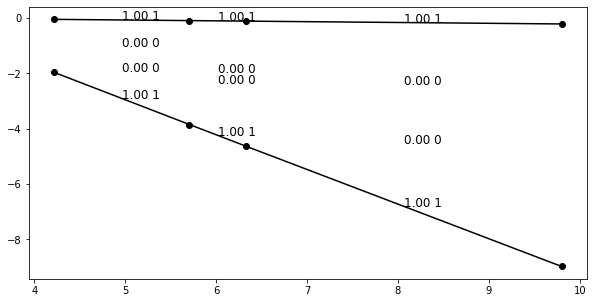

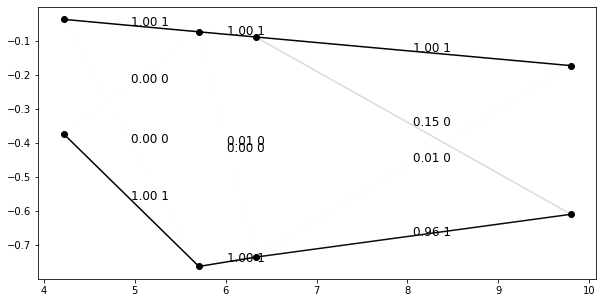

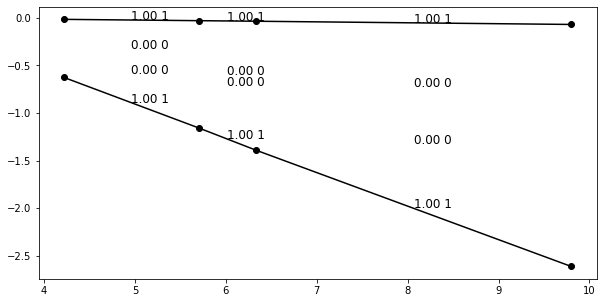

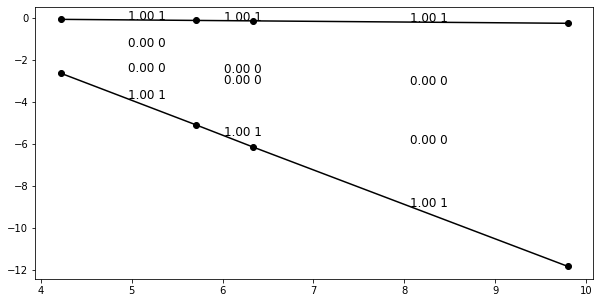

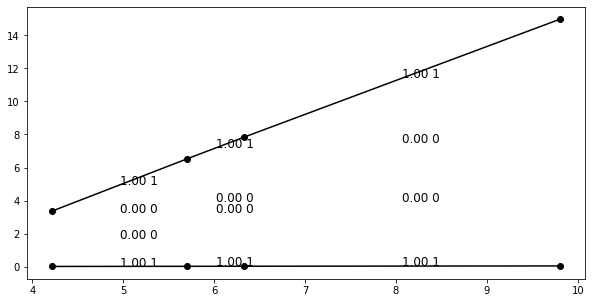

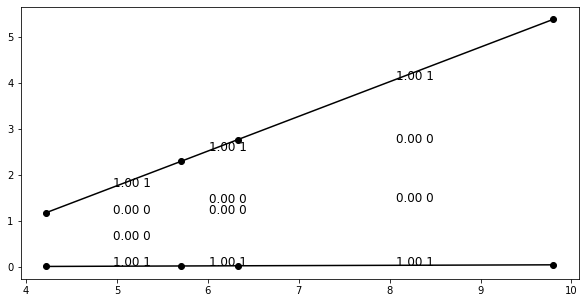

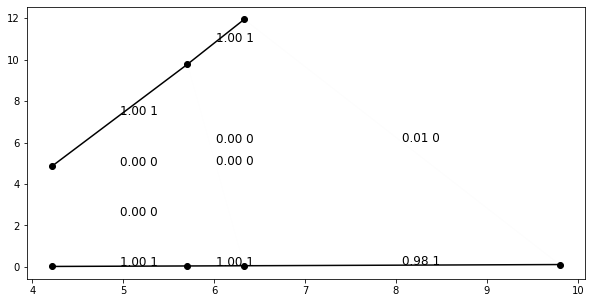

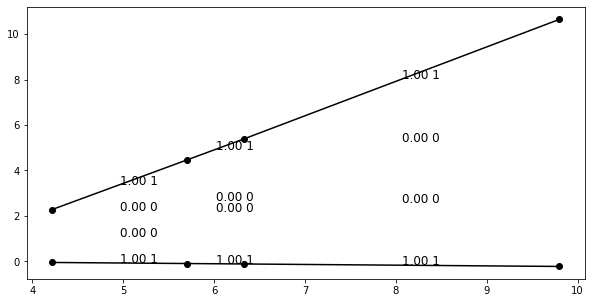

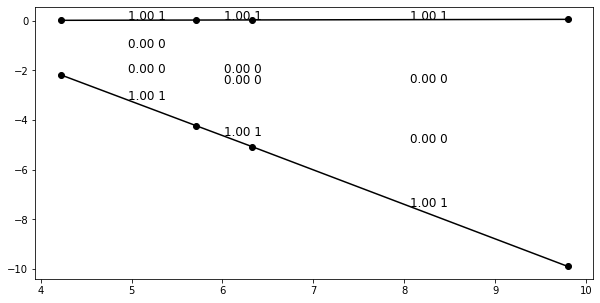

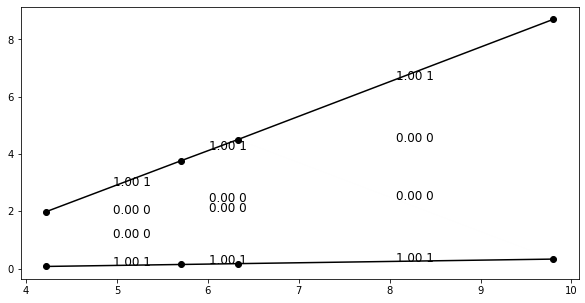

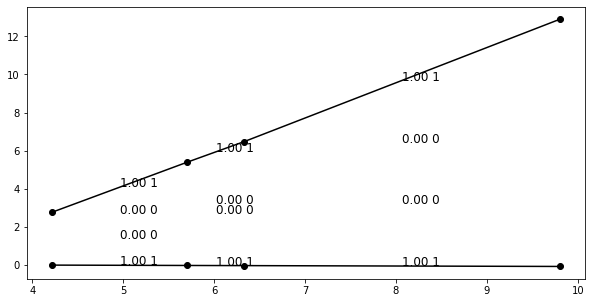

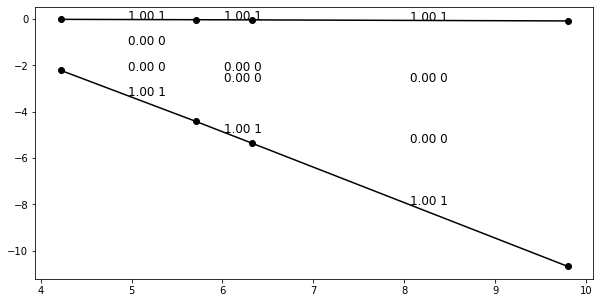

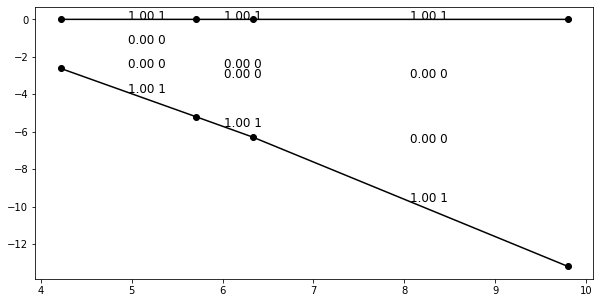

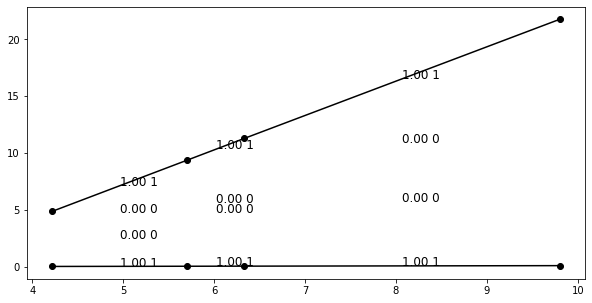

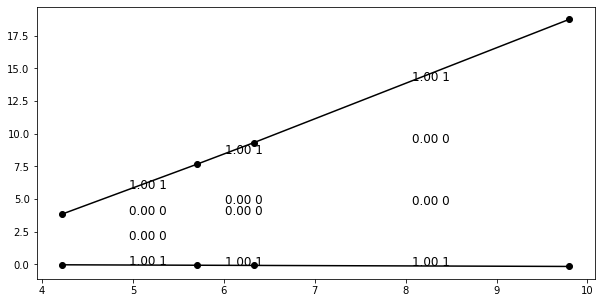

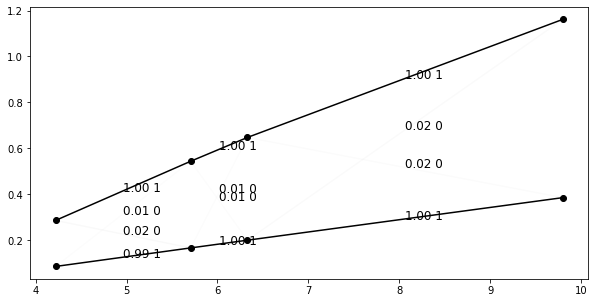

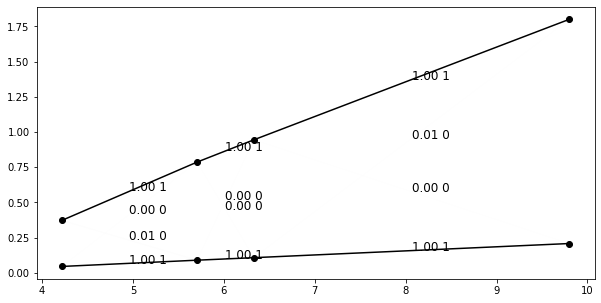

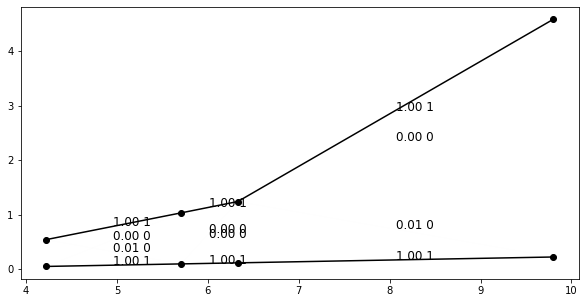

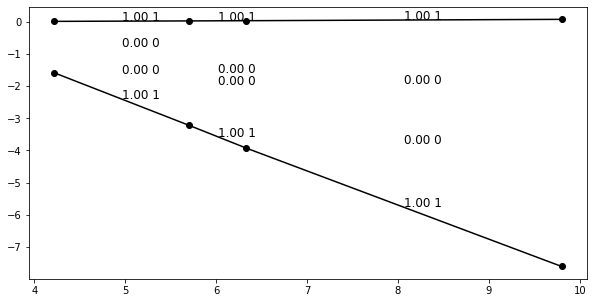

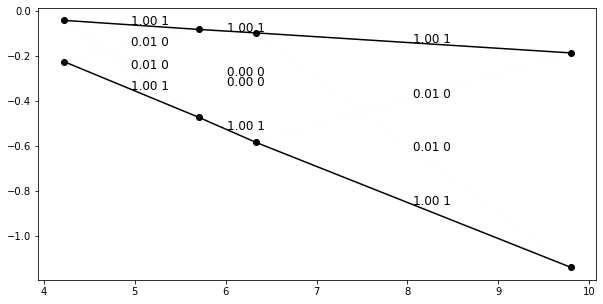

In [ ]:
for i in range(20):
  data = train_loader.dataset[i].to(device)
  preds = torch.sigmoid(model(data)).to('cpu')
  plot_toy_classified(data.to('cpu'), preds, cut = 0.6)
  #plot_toy_graph(train_loader.dataset[2],0.2)